# Data Checks Tutorial

## Outline
1. What data do we need for SFS-based demographic inference
2. Our Example Dataset
3. VCF filtering
4. Data quality control 1: PCA
5. Data quality control 2: HWE
6. LD pruning
7. Hands on!

## 1. What data do we need to build SFS from VCF?

- VCF with **biallelic single nucleotide variants**
- As many SNP's as possible
- As many individuals as possible (8-10 okay, 100 better)
- Remove relatives
- Use neutral sites or intergenic regions (similar evolution forces)
- Remove multiallelic, indels
- No MAF-filtering (!)
- ~~Avoid missing data~~ (`easySFS` and `ATLAS` can help with missing data)

-----
## 2.  Our Example Dataset

We have a dataset for clouded leopards (*Neofelis nebulosa*). It is an example data for one contig (10,000,000 bp) for 10 diploid individuals (20 haploid samples).

All the data is available in the `data` folder:

In [1]:
%%bash
ls data

example_data.vcf
popmap.txt


- File `data/example_data.vcf` is our VCF file for all 10 individuals (single chromosome of 10,000,000 bp):

In [2]:
%%bash
# First five lines
head -6 data/example_data.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##source=tskit 0.5.7
##contig=<ID=CONTIG1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


In [3]:
%%bash
# The header line of the VCF file (we take first 9 lines of file and then show the last one)
head -6 data/example_data.vcf | tail -1

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


- File `data/popmap.txt` provides population assignments per individual (all our individuals are from the same population that is marked as `NN`):

In [4]:
%%bash
cat data/popmap.txt

Leopard01 NN
Leopard02 NN
Leopard03 NN
Leopard04 NN
Leopard05 NN
Leopard06 NN
Leopard07 NN
Leopard08 NN
Leopard09 NN
Leopard10 NN


-----
## 3. VCF filtering

We require VCF with **biallelic single-nucleotide** variants. The example VCF already has SNPs only. If your VCF contains multi-nucleotide variants, then it is better to do [VCF normalization](https://samtools.github.io/bcftools/bcftools.html#norm) (with `--fasta-ref` option if possible).

Having our VCF file we can filter all mutiallelic, multi-nucleotide variants and indels using bcftools (you can easily install it via `conda install bcftools`):

In [16]:
%%bash
bcftools view -m2 -M2 -v snps data/example_data.vcf -Ov -o data/biallelic_snps.vcf

We can get the total number of variants we have:

In [17]:
%%bash
bcftools view -H data/biallelic_snps.vcf | wc -l

544032


**We will use this value later to calculate the length of sequence for GADMA.**

--------
## 4. Data quality control 1: PCA

Now we will check for the quality of samples. We would run principal component analysis (PCA) to check for the population structure.

**Principal Component Analysis (PCA)** helps to summarize genetic variation across individual samples into a few principal components, each representing a direction of maximum variance. By plotting these components, researchers can visually assess population structure, detect outliers, and identify subgroups or clusters within the data. This allows for quality control by highlighting samples that differ significantly from the main population, which may indicate technical artifacts, mislabeling, or underlying biological differences.

**Recommendations for Performing PCA in Genetic Data Analysis:**

* **Apply PCA to all samples across all populations:**
begin by running PCA on the entire dataset, including all samples from all populations, to assess overall population structure.

* **Check both all variants and LD-pruned variants:**
perform PCA on both the full set of variants and on independent variants (after LD pruning).

* **Repeat PCA within each population:**
analyze populations separately to detect within-population substructure and outliers.

* **Check for outliers and anomalies:**
review PCA plots to identify any outlier or mislabeled samples.

You can do PCA plot using `plink`, you can find detailed instructions [here](https://speciationgenomics.github.io/pca/). However, today we are going to use custom scripts for that.

To have a nice picture in this notebook we will use the script through python:

[INFO] Reading popmap...
[INFO] 10 samples, 1 populations detected
[INFO] Reading VCF (this might take a while)...
[INFO] Data shape after filtering: (10, 544032)
[INFO] Running PCA...
[INFO] Displaying ...


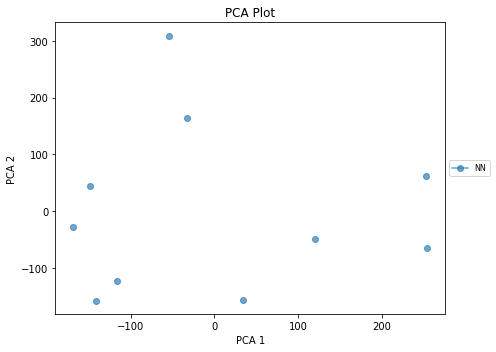

[INFO] Done.


In [18]:
from scripts.draw_PCA_plot import pca_plot

# To save to a file:
pca_plot(vcf_file="data/biallelic_snps.vcf",
         popmap_file="data/popmap.txt",
         output_file=None,  # output here
         only_full_data=False,  # missing data will be filled with mean values
         double_ids=True,
         show_sample_names=False,  # If True sample names will be pictured on the plot
)

However, you can run script from command line the following way (the same picture will appear if you use it from the command line interface):

In [14]:
%%bash
python scripts/draw_PCA_plot.py --help

usage: draw_PCA_plot.py [-h] [--full] [--show-sample-names] [--double-ids]
                        vcf popmap [output]

Draw PCA plot from VCF and popmap files.

positional arguments:
  vcf                  VCF filename
  popmap               Popmap filename (tab-separated: sample pop)
  output               Output file for the plot (e.g., pca.png); if omitted,
                       plot will be shown interactively

options:
  -h, --help           show this help message and exit
  --full               Use only full data rows (exclude missing genotypes)
  --show-sample-names  Display sample names on the plot at each point
  --double-ids         VCF contains doubled ids for samples (result of LD
                       pruning using plink)


In [19]:
%%bash
python scripts/draw_PCA_plot.py --show-sample-names data/biallelic_snps.vcf data/popmap.txt my_pca.pdf

[INFO] Reading popmap...
[INFO] 10 samples, 1 populations detected
[INFO] Reading VCF (this might take a while)...
[INFO] Data shape after filtering: (10, 544032)
[INFO] Running PCA...
[INFO] Saving to my_pca.pdf ...
[INFO] Done.


## 5. Data quality control 2: HWE

An additional sanity check is the test for Hardy-Weinberg Equilibrium (HWE). Deviations from HWE (such as a significant excess or deficit of heterozygotes or homozygotes) can indicate genotyping problems or high inbreeding coefficient (e.g. in selfing species).

The HWE principle describes the expected distribution of genotype frequencies (homozygotes and heterozygotes) under conditions of random mating, no selection, and no population structure. In well-behaved, high-quality genetic datasets, most loci are expected to approximately follow these theoretical proportions.

By drawing an HWE ternary plot, we can visually assess whether our data conform to these expectations or if systematic deviations exist. Such deviations may be early warning signs of technical issues in the dataset (for example, genotyping errors, sample contamination, or problematic variants), or reflect biological factors such as inbreeding or population substructure.

<div>
<img src="pictures/HWE_ternary_plot_example.png" width="300" align="left" />
</div>
Source: Graffelman & Camarena (2008)

**What are ternary coordinates?**
<div>
<img src="pictures/ternary_coordinates.png" width="300" align="left" />
</div>

[Source](https://demonstrations.wolfram.com/BasicTernaryPhaseDiagram/)


The paper by [Graffelman & Camarena (2008)](https://doi.org/10.1159/000108939)  describe both statistical tests and graphical tools for assessing Hardy-Weinberg equilibrium. Their paper introduces the use of chi-squared and continuity-corrected chi-squared tests to identify deviations from HWE, and shows how to visualize the **acceptance region**—where genotype frequencies are consistent with HWE at a chosen significance level (e.g., α = 0.05)—on the ternary plot.

Methods from the paper are implemented in [R library `HardyWeinberg`](https://doi.org/10.32614/CRAN.package.HardyWeinberg). The ternary plot is available via the HWTernaryPlot function. For users working with VCF data, files can be loaded into R using the [`vcfR` package](https://doi.org/10.32614/CRAN.package.vcfR). Example result:
<div>
<img src="pictures/Rplot_HWE.png" width="500" align="left" />
</div>

**Recommendations for Testing Hardy-Weinberg Equilibrium (HWE):**

* **Test HWE for each population separately:**
build HWE ternary plots within each population.

* **Check both all variants and LD-pruned variants:**
perform HWE check on both the full set of variants and on independent variants (after LD pruning).

* **Investigate Excess Heterozygosity:**
Check for variants with excess heterozygotes, as this may indicate genotyping errors or technical artifacts.

* **Monitor for Excess Homozygosity:**
Observe variants with unusually high levels of homozygosity, which could reflect inbreeding.

In this tutorial, we will use a modified python version of the approach from [Graffelman & Camarena (2008)](https://doi.org/10.1159/000108939). The solid lines present the acceptance region ($\alpha=0.05$) for HWE based on $\chi^2$ test and dashed lines refer to acceptance region ($\alpha=0.05$) for a $\chi^2$ test with continuity correction.

/home/enoskova/Workspace/GADMA_workshops/2025-11-Demographic_Inference_Worshop/tutorials/2_data_checks_tutorial/scripts/draw_HWE_ternary_plot.py:143: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


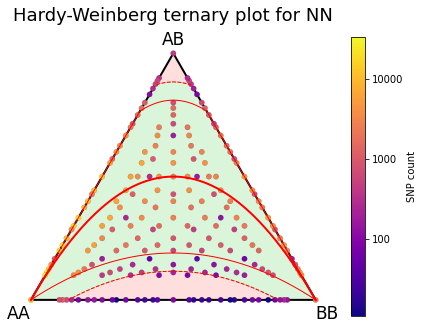

In [10]:
from scripts.draw_HWE_ternary_plot import hwe_ternary_plot

# To save to a file:
hwe_ternary_plot(vcf_file="data/biallelic_snps.vcf",
                 popmap_file="data/popmap.txt",
                 population_name="NN"
)

In order to run script from command line:

In [11]:
%%bash
python scripts/draw_HWE_ternary_plot.py --help

usage: draw_HWE_ternary_plot.py [-h] [-o OUTPUT] [--double-ids]
                                vcf popmap population

Draw a Hardy-Weinberg ternary plot for one population using a VCF and popmap.
Green background shows 'inside bounds', red otherwise.

positional arguments:
  vcf                   Input VCF file
  popmap                Popmap file
  population            Population name (as in popmap)

options:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        Output file (default: interactive)
  --double-ids          VCF contains doubled ids for samples (result of LD
                        pruning using plink)


In [20]:
%%bash
python scripts/draw_HWE_ternary_plot.py --output HWE_ternary_plot.pdf data/biallelic_snps.vcf data/popmap.txt NN

/home/enoskova/Workspace/GADMA_workshops/2025-11-Demographic_Inference_Worshop/tutorials/2_data_checks_tutorial/scripts/draw_HWE_ternary_plot.py:143: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


[INFO] Saved plot to HWE_ternary_plot.pdf


-----
## 6. LD pruning
Linked sites can influence PCA and HWE plots. **It is worth checking if the plots are similar for LD pruned data.**

In order to do LD pruning, we will use `plink` (the download is available [here](https://www.cog-genomics.org/plink/)).

#### Install `plink`
We are installing plink for Linux system, you can use the following link for MacOS: `https://s3.amazonaws.com/plink1-assets/plink_mac_20250819.zip`.

In [6]:
%%bash
mkdir plink
cd plink
wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20250819.zip
unzip plink_linux_x86_64_20250819.zip

--2025-10-16 12:06:12--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20250819.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.234.32, 16.15.186.160, 16.15.177.39, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.234.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6321240 (6.0M) [application/zip]
Saving to: ‘plink_linux_x86_64_20250819.zip’

     0K .......... .......... .......... .......... ..........  0%  546K 11s
    50K .......... .......... .......... .......... ..........  1%  385K 13s
   100K .......... .......... .......... .......... ..........  2%  786K 11s
   150K .......... .......... .......... .......... ..........  3% 1.75M 9s
   200K .......... .......... .......... .......... ..........  4%  659K 9s
   250K .......... .......... .......... .......... ..........  4% 7.97M 8s
   300K .......... .......... .......... .......... ..........  5% 1.49M 7s
   350K .......... .......... .......... .......... ...

  5150K .......... .......... .......... .......... .......... 84% 15.0M 0s
  5200K .......... .......... .......... .......... .......... 85% 2.60M 0s
  5250K .......... .......... .......... .......... .......... 85% 1.01M 0s
  5300K .......... .......... .......... .......... .......... 86% 8.52M 0s
  5350K .......... .......... .......... .......... .......... 87% 10.9M 0s
  5400K .......... .......... .......... .......... .......... 88% 6.79M 0s
  5450K .......... .......... .......... .......... .......... 89% 14.3M 0s
  5500K .......... .......... .......... .......... .......... 89% 32.0M 0s
  5550K .......... .......... .......... .......... .......... 90% 2.91M 0s
  5600K .......... .......... .......... .......... .......... 91% 12.4M 0s
  5650K .......... .......... .......... .......... .......... 92%  972K 0s
  5700K .......... .......... .......... .......... .......... 93% 18.7M 0s
  5750K .......... .......... .......... .......... .......... 93% 14.2M 0s
  5800K ....

Archive:  plink_linux_x86_64_20250819.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


check that `plink` is working:

In [7]:
%%bash
./plink/plink --help

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3

In the command line flag definitions that follow,
  * <angle brackets> denote a required parameter, where the text between the
    angle brackets describes its nature.
  * ['square brackets + single-quotes'] denotes an optional modifier.  Use the
    EXACT text in the quotes.
  * [{bar|separated|braced|bracketed|values}] denotes a collection of mutually
    exclusive optional modifiers (again, the exact text must be used).  When
    there are no outer square brackets, one of the choices must be selected.
  * ['quoted_text='<description of value>] denotes an optional modifier that
    must begin with the quoted text, and be followed by a value with no
    whitespace in between.  '|' may also be used here to indicate mutually
    exclusive options.
  * [square brackets without quotes or braces] denote an optional parameter,
    whe

    * The 'tab' modifier makes the output mostly tab-delimited instead of
      mostly space-delimited.  'tabx' and 'spacex' force all tabs and all
      spaces, respectively.

  --flip-scan ['verbose']
    (alias: --flipscan)
    LD-based scan for case/control strand inconsistency.

  --write-covar
    If a --covar file is loaded, --make-bed/--make-just-fam and --recode
    automatically generate an updated version (with all filters applied).
    However, if you do not wish to simultaneously generate a new genotype file,
    you can use --write-covar to just produce a pruned covariate file.

  --write-cluster ['omit-unassigned']
    If clusters are specified with --within/--family, this generates a new
    cluster file (with all filters applied).  The 'omit-unassigned' modifier
    causes unclustered samples to be omitted from the file; otherwise their
    cluster is 'NA'.

  --write-set
  --set-table
    If sets have been defined, --write-set dumps 'END'-terminated set
    membership

    Generate a list of markers in approximate linkage equilibrium.  With the
    'kb' modifier, the window size is in kilobase instead of variant count
    units.  (Pre-'kb' space is optional, i.e. "--indep-pairwise 500 kb 5 0.5"
    and "--indep-pairwise 500kb 5 0.5" have the same effect.)
    Note that you need to rerun PLINK using --extract or --exclude on the
    .prune.in/.prune.out file to apply the list to another computation.

  --r [{square | square0 | triangle | inter-chr}] [{gz | bin | bin4}]
      ['spaces'] ['in-phase'] [{d | dprime | dprime-signed}] ['with-freqs']
      ['yes-really']
  --r2 [{square | square0 | triangle | inter-chr}] [{gz | bin | bin4}]
       ['spaces'] ['in-phase'] [{d | dprime | dprime-signed}] ['with-freqs']
       ['yes-really']
    LD statistic reports.  --r yields raw inter-variant correlations, while
    --r2 reports their squares.  You can request results for all pairs in
    matrix format (if you specify 'bin', 'bin4', or one of the shape
    m

    the list of remaining samples to be written to disk, this will save it to
    <output prefix>.rel.id.
    Note that maximizing the remaining sample size is equivalent to the NP-hard
    maximum independent set problem, so we use a greedy algorithm instead of
    guaranteeing optimality.  (Use the --make-rel and --keep/--remove flags if
    you want to try to do better.)

  --ibs-test [permutation count]
  --groupdist [iters] [d]
    Given case/control phenotype data, these commands consider three subsets of
    the distance matrix: pairs of affected samples, affected-unaffected pairs,
    and pairs of unaffected samples.  Each of these subsets has a distribution
    of pairwise genomic distances; --ibs-test uses permutation to estimate
    p-values re: which types of pairs are most similar, while --groupdist
    focuses on the differences between the centers of these distributions and
    estimates standard errors via delete-d jackknife.

  --regress-distance [iters] [d]
    Linear

      number of replications to be performed.
    * 'perm-count' causes the permutation test report to include counts instead
      of frequencies.
    * 'counts' causes --assoc to report allele counts instead of frequencies.
    * 'set-test' tests the significance of variant sets.  Requires permutation;
      can be customized with --set-p/--set-r2/--set-max.
    * 'dom', 'rec', 'gen', and 'trend' force the corresponding test to be used
      as the basis for --model permutation.  (By default, the most significant
      result among the allelic, dominant, and recessive tests is used.)
    * 'trend-only' causes only the trend test to be performed.
    Given a quantitative phenotype, --assoc normally performs a Wald test.
    * In this case, the 'qt-means' modifier causes trait means and standard
      deviations stratified by genotype to be reported as well.
    * 'lin' causes the Lin statistic to be computed, and makes it the basis for
      multiple-testing corrections and permutatio

    of thousands) to be effective on complex polygenic traits.

  --test-missing ['perm' | 'mperm='<value>] ['perm-count'] ['midp']
    Check for association between missingness and case/control status, using
    Fisher's exact test.  (Het. haploids are treated as missing.)
    The 'midp' modifier causes Lancaster's mid-p adjustment to be applied.

  --make-perm-pheno <ct>
    Generate phenotype permutations and write them to disk, without invoking an
    association test.

  --tdt [{exact | exact-midp | poo}] ['perm' | 'mperm='<value>] ['perm-count']
        [{parentdt1 | parentdt2 | pat | mat}] ['set-test']
    Report transmission disequilibrium test statistics, given case/control
    phenotypes and pedigree information.
    * A Mendel error check is performed before the main tests; offending
      genotypes are treated as missing by this analysis.
    * By default, the basic TDT p-value is based on a chi-square test unless
      you request the exact binomial test with 'exact' or 'e

    report can be assembled at the end by applying Unix 'cat' in the usual
    manner, but the .summary.1, .summary.2, ... files may require a specialized
    merge.  --epistasis-summary-merge takes care of the latter.

  --twolocus <variant ID> <variant ID>
    Two-locus joint genotype count report.

  --score <filename> [i] [j] [k] ['header'] [{sum | no-sum}]
          [{no-mean-imputation | center}] ['include-cnt'] ['double-dosage']
    Apply a linear scoring system to each sample.
    The input file should have one line per scored variant.  Variant IDs are
    read from column #i, allele codes are read from column #j, and scores are
    read from column #k, where i defaults to 1, j defaults to i+1, and k
    defaults to j+1.
    * The 'header' modifier causes the first nonempty line of the input file to
      be ignored; otherwise, --score assumes there is no header line.
    * By default, final scores are averages of the valid per-variant scores.
      The 'sum' modifier causes su

                            (Note that, in some shells, it is necessary to
                            surround the * with quotes.)
                            Otherwise, all samples with third column entry
                            equal to the val parameter are cases, and all other
                            samples mentioned in the file are controls.
  --tail-pheno <Lt> [Hbt] : Downcode a scalar phenotype to a case/control
                            phenotype.  All samples with phenotype values
                            greater than Hbt are cases, and all with values
                            less than or equal to Lt are controls.  If Hbt is
                            unspecified, it is equal to Lt; otherwise,
                            in-between phenotype values are set to missing.
  --covar <filename> ['keep-pheno-on-missing-cov'] : Specify covariate file.
  --covar-name <...>       : Specify covariate(s) in --covar file by name.
                             Separate mu

  --prune             : Remove samples with missing phenotypes.
  --maf [freq]        : Exclude variants with minor allele frequency lower than
                        a threshold (default 0.01).
  --max-maf <freq>    : Exclude variants with MAF greater than the threshold.
  --mac <ct>          : Exclude variants with minor allele count lower than the
    (alias: --min-ac)   given threshold.
  --max-mac <ct>      : Exclude variants with minor allele count greater than
    (alias: --max-ac)   the given threshold.
  --maf-succ       : Rule of succession MAF estimation (used in EIGENSOFT).
                     Given j observations of one allele and k >= j observations
                     of the other, infer a MAF of (j+1) / (j+k+2), rather than
                     the default j / (j+k).
  --read-freq <fn> : Estimate MAFs and heterozygote frequencies from the given
                     --freq[x] report, instead of the input fileset.
  --hwe <p> ['midp'] ['include-nonctrl'] : Exclude vari

                         For now, only --merge/--bmerge/--merge-list and
                         --make-bed/--make-just-fam respect this flag.
  --with-phenotype ['no-parents'] [{no-sex | female-2}] :
    Include more sample info in new .cov file.
  --dummy-coding [N] ['no-round'] : Split categorical variables (n categories,
                                    2 < n <= N, default N is 49) into n-1
                                    binary dummy variables when writing
                                    covariate file.
  --merge-mode <n>   : Adjust --[b]merge/--merge-list behavior based on a
                       numeric code.
                       1 (default) = ignore missing calls, otherwise difference
                                     -> missing
                       2 = only overwrite originally missing calls
                       3 = only overwrite when nonmissing in new file
                       4/5 = never overwrite and always overwrite, respectively
                  

                        1 (default) = add sex as a covariate on X chromosome
                        2 = code male genotypes 0/2 instead of 0/1
                        3 = test for interaction between genotype and sex
  --lasso-select-covars [cov(s)...] : Subject some or all covariates to LASSO
                                      model selection.
  --adjust ['gc'] ['log10'] ['qq-plot'] : Report some multiple-testing
                                          corrections.
  --lambda <val>   : Set genomic control lambda for --adjust.
  --ci <size>      : Report confidence intervals for odds ratios.
  --pfilter <val>  : Filter out association test results with higher p-values.
  --aperm <min perms - 1> [max perms] [alpha] [beta] [init interval] [slope] :
    Set up to six parameters controlling adaptive permutation tests.
    * The first two control the minimum and maximum number of permutations that
      may be run for each variant; default values are 5 and 1000000.
    * The next two 

  --debug            : Use slower, more crash-resistant logging method.

Primary methods paper:
Chang CC, Chow CC, Tellier LCAM, Vattikuti S, Purcell SM, Lee JJ (2015)
Second-generation PLINK: rising to the challenge of larger and richer datasets.
GigaScience, 4.

For further documentation and support, consult the main webpage
(https://www.cog-genomics.org/plink/1.9 ) and/or the mailing list
(https://groups.google.com/d/forum/plink2-users ).


#### Run LD pruning using `plink`

We are using the following arguments:
- `--vcf` — specifies the location of your VCF file.
- `--double-id`  — sets both family and individual IDs in the PLINK files to your sample ID. This is necessary because PLINK expects separate family and individual IDs (for pedigree analysis), but for most population genetic analyses, duplicating the sample ID is sufficient.
- `--allow-extra-chr` — allows chromosomes beyond the standard human set (1-22, X, Y, MT). This is required if your VCF uses non-human or custom chromosome names.
- `--set-missing-var-ids @:#` — assigns variant IDs in the format chromosome:position when IDs are missing. Many non-human VCFs don't have SNP names, so this ensures PLINK can uniquely identify each variant.
- `--indep-pairwise 50 5 0.1` — performs LD pruning. Here, 50 is the window size in SNPs, 10 is the step size (how far the window advances), and 0.1 is the r² threshold; SNPs with stronger LD than this threshold are pruned out.
- `--out` — sets the prefix for all output files.

In [8]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --indep-pairwise 50 5 0.1 --out data/pruned_variants

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/pruned_variants.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 5 0.1
  --out data/pruned_variants
  --set-missing-var-ids @:#
  --vcf data/biallelic_snps.vcf

31799 MB RAM detected; reserving 15899 MB for main workspace.
--vcf: data/pruned_variants-temporary.bed + data/pruned_variants-temporary.bim
+ data/pruned_variants-temporary.fam written.
544032 variants loaded from .bim file.
10 people (0 males, 0 females, 10 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/pruned_variants.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 10 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737

Now we will convert our pruned variants back to VCF format. Our final file is `data/pruned_variants.vcf`.

In [1]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --extract data/pruned_variants.prune.in --recode vcf --out data/pruned_variants

PLINK v1.9.0-b.7.11 64-bit (19 Aug 2025)           cog-genomics.org/plink/1.9/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/pruned_variants.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --extract data/pruned_variants.prune.in
  --out data/pruned_variants
  --recode vcf
  --set-missing-var-ids @:#
  --vcf data/biallelic_snps.vcf

31799 MB RAM detected; reserving 15899 MB for main workspace.
--vcf: data/pruned_variants-temporary.bed + data/pruned_variants-temporary.bim
+ data/pruned_variants-temporary.fam written.
544032 variants loaded from .bim file.
10 people (0 males, 0 females, 10 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/pruned_variants.nosex .
--extract: 10018 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 10 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

## 7. Hands on!

Now it’s your turn to practice data checking!

### Orangutan Dataset for Practical Sessions
You can follow the step-by-step tutorial using the same example dataset demonstrated above, or try it on a **different dataset** for additional practice. You can also use this dataset throughout the GADMA tutorial.

For the practical sessions, we provide genetic data from two populations of orangutans. The [dataset](https://drive.google.com/drive/folders/1ZBT9aJxs-OUmzpsAj0BHflXgBK1FRpK6?usp=sharing) includes:

* VCF file (`chr1.vcf.gz`): Contains SNP data for chromosome 1, which is 227,913,704 base pairs long.
* Popmap file (`popmap.txt`): Indicates the population assignment for each sample. There are two populations—Bornean and Sumatran orangutans—with 10 samples each.
* The mutation rate is set to 1.5 × 10⁻⁸ per base pair per generation.

After completing your analyses and looking at the resulting plots, can you already say something about the demographic history of these two populations? What patterns or signals do you see in your results?

You can share your results with us [here](https://forms.office.com/e/22WG3W8ATu).